### INTRODUCCIÓN

El objetivo de este proyecto es tomar los datos meteorológicos disponibles  y aplicar técnicas de aprendizaje automático para predecir la cantidad de concentración de PM2,5 en el aire, dadas otras características ambientales. 
Para abordar dicha tarea, se realizará un análisis a la serie de tiempo. Esto incluirá:

* Exploración y limpieza de datos.
* Uso de gráficos y estadísticas descriptivas para seleccionar las variables independientes.
* Creación de un modelo de regresión.
* Comprobación de los supuestos del modelo.


#### PASO 1: Importaciones
Importar paquetes relevantes

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

from sklearn.metrics import r2_score,mean_squared_error





#### PASO 2: Cargar datos

In [2]:
df = pd.read_csv('data.txt')  

#### PASO 3: Manipulación de datos

In [3]:
df.dtypes #verificando tipos

No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

In [4]:
df['cbwd'].unique() #tenemos la siguiente varible categorica

array(['NW', 'cv', 'NE', 'SE'], dtype=object)

In [5]:
#¿Cuantos valores nulos tenemos?
df.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [6]:
df.shape

(43824, 13)

In [7]:
2067*100/43824

4.716593647316539

Notamos que los valores nulos representan menos de 5% en la columna pm2.5. Asi, procedemos a eliminarlos 

In [8]:
df.dropna(inplace=True)

In [9]:
df.shape

(41757, 13)

Eliminamos tambien la columna 'No' pues no tiene ninguna utilidad

In [10]:
df.drop(['No'],axis=1,inplace=True)

In [11]:
df.reset_index(drop=True,inplace=True) # reiniciando indices

Juntaremos las cuatro columnas 'year','month','day','hour' en una sola 'date' y esa columna sera el indice del dataframe

In [12]:
df['date'] = pd.to_datetime(df[['year','month','day','hour']])

In [13]:
df.drop(columns=['year','month','day','hour'],inplace=True) 

In [14]:
df.index = df['date'] # indice del dataframe

In [15]:
df.drop(columns=['date'],inplace=True) # eliminado columna innecesaria

In [16]:
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [17]:
y = df['pm2.5']

Consideremos nuestra serie de tiempo:

In [18]:
y

date
2010-01-02 00:00:00    129.0
2010-01-02 01:00:00    148.0
2010-01-02 02:00:00    159.0
2010-01-02 03:00:00    181.0
2010-01-02 04:00:00    138.0
                       ...  
2014-12-31 19:00:00      8.0
2014-12-31 20:00:00     10.0
2014-12-31 21:00:00     10.0
2014-12-31 22:00:00      8.0
2014-12-31 23:00:00     12.0
Name: pm2.5, Length: 41757, dtype: float64

#### PASO 4 : EXPLORACIÓN DE DATOS 

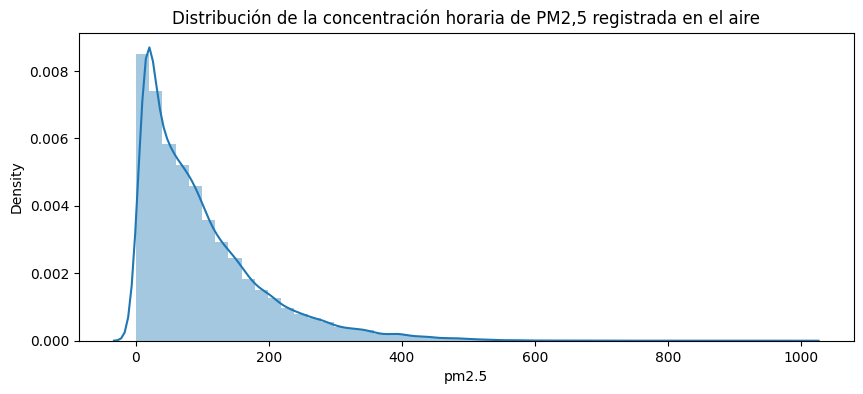

In [19]:
plt.figure(figsize=(10,4))
sns.distplot(y,bins=50)
plt.title('Distribución de la concentración horaria de PM2,5 registrada en el aire', fontsize=12)
plt.show()

In [20]:
x=y.copy()


In [21]:
x = x.asfreq('D', method='ffill')


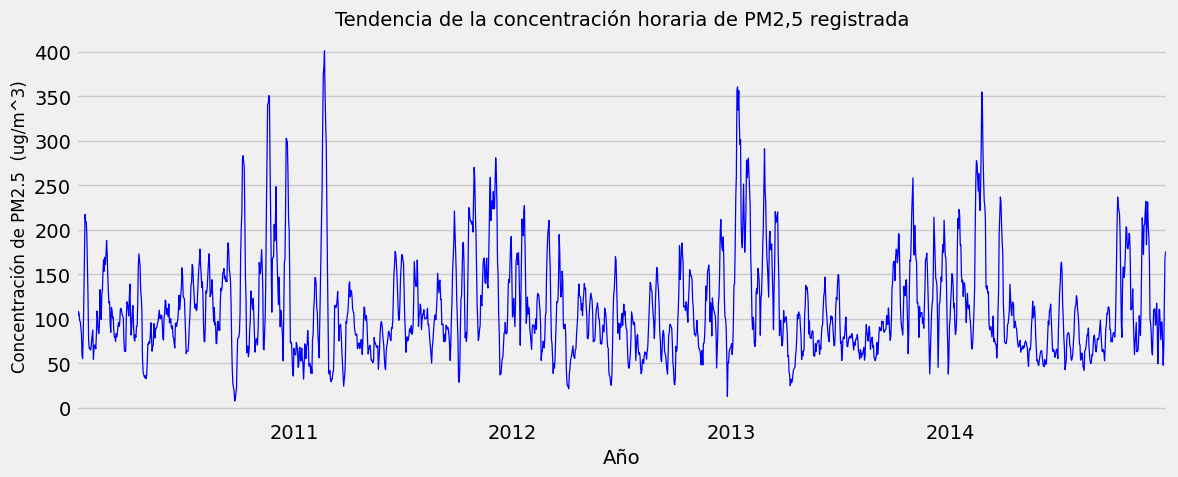

In [22]:


# Realiza la descomposición
decomposition = seasonal_decompose(x, model='additive')

# grafica 
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(12, 5), style='b-', linewidth=0.9, legend=False)
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Concentración de PM2.5  (ug/m^3)', fontsize=12)
    plt.title('Tendencia de la concentración horaria de PM2,5 registrada', fontsize=14)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

Observaciones: Cada comienzo de año(primeros meses) se vive un pico en la concentración de Pm2.5 en el aire.

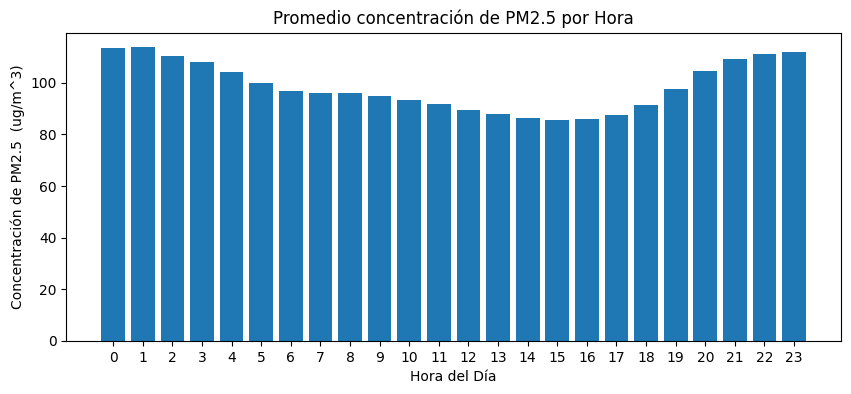

In [23]:
#promedio diario de PM2.5 contenidas en el aire en una hora determinada.
diario_prom_y = y.groupby(y.index.hour).mean()

# Crea el gráfico de barras
plt.figure(figsize=(10, 4))
plt.bar(diario_prom_y.index, diario_prom_y.values)
plt.xlabel('Hora del Día')
plt.ylabel('Concentración de PM2.5  (ug/m^3)')
plt.title('Promedio concentración de PM2.5 por Hora')
plt.xticks(range(24))
plt.show()

Observación: Las horas con mas concentracion de pm2.5 en el aire son entre 9 pm y 3 am. 

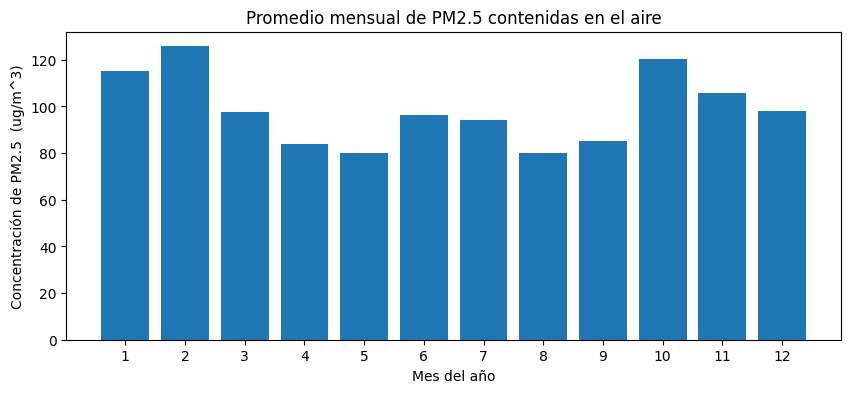

In [24]:
#promedio mensual de PM2.5 contenidas en el aire.
diario_prom_y = y.groupby(y.index.month).mean()

# Crea el gráfico de barras
plt.figure(figsize=(10, 4))
plt.bar(diario_prom_y.index, diario_prom_y.values)
plt.xlabel('Mes del año')
plt.ylabel('Concentración de PM2.5  (ug/m^3)')
plt.title('Promedio mensual de PM2.5 contenidas en el aire')
plt.xticks(range(1,13))
plt.show()

Observación: Los meses de mayor concentración de pm2.5 en el aire son enero, febrero y octubre.

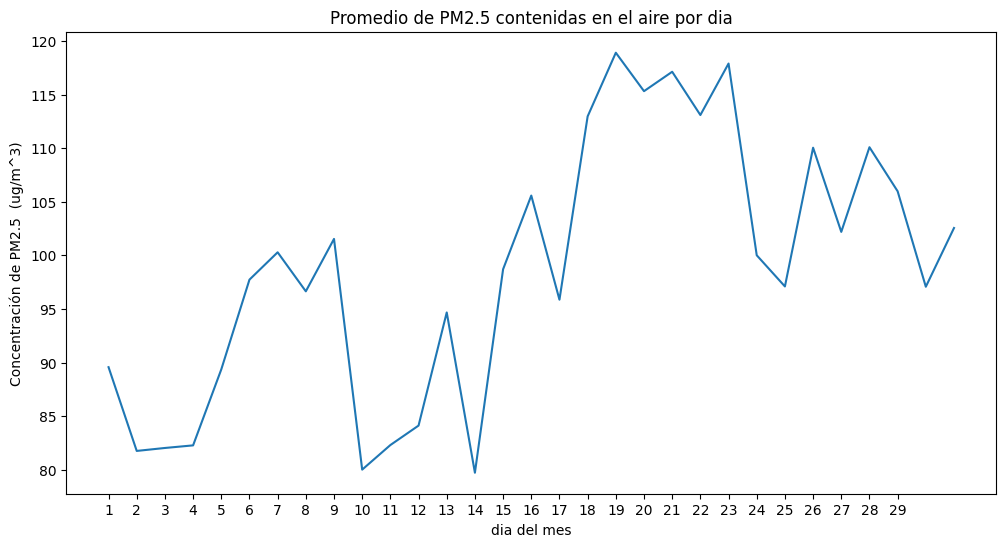

In [25]:
diario_prom_y = y.groupby(y.index.day).mean()

# Crea el gráfico de barras
plt.figure(figsize=(12, 6))
plt.plot(diario_prom_y.index, diario_prom_y.values)
plt.xlabel('dia del mes')
plt.ylabel('Concentración de PM2.5  (ug/m^3)')
plt.title('Promedio de PM2.5 contenidas en el aire por dia')
plt.xticks(range(1,30))
plt.show()

observación: Entre los dias 17 y 23 de cada mes se ve un aumento en la concentración de pm2.5 en el aire.

Veamos como estan correlacionados las variables entre si.



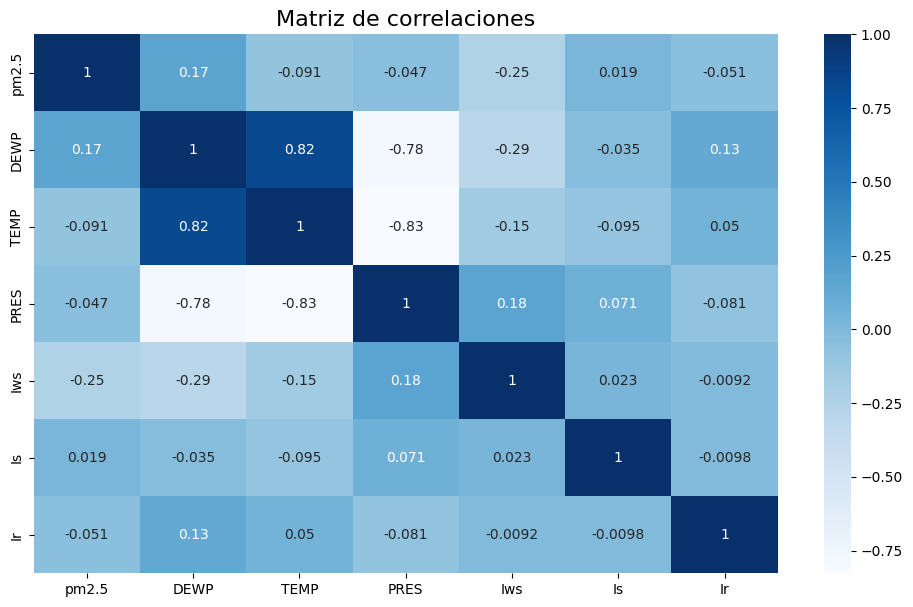

In [26]:
plt.figure(figsize=(12,7))
correlation_data = df[['pm2.5',
 'DEWP',
 'TEMP',
 'PRES',
 'Iws',
 'Is',
 'Ir']]
sns.heatmap(correlation_data.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Matriz de correlaciones',fontsize=16)
plt.show()

#### PASO 5: Feature Engineering 

De lo anterior podemos notar una correlación entre las variables DEWP y TEMP. Dado que queremos aplicar un modelo de regresión lineal(multiple), debemos verificar que se cumplen los supuestos, estos son:

1. Linealidad --- ok

2. Independencia --- ok

3. Homocedasticidad --- Se verficará cuando se obtegan los residuos.

4. Normalidad de los residuos --- Se verficará cuando se obtegan los residuos.

5. No multicolinealidad: Para verficar esta condicion vamos utilizar Factor de inflacion de la varianza, en ingles (VIF).

In [27]:
cols_borrar = ['cbwd']
data = df.drop(cols_borrar,axis=1)

# Calcula el factor de inflación de la varianza de cada característica y detecta multicolinealidad
cons_data = sm.tools.add_constant(data)
serie_antes = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
serie_antes

const    34827.373742
pm2.5        1.309135
DEWP         4.430096
TEMP         5.311927
PRES         3.522716
Iws          1.156202
Is           1.017042
Ir           1.044735
dtype: float64

In [28]:
#Podemos ver que TEMP (temperatura) y DEWP (punto de rocío) están altamente correlacionados 
#ya que el valor VIF es mayor que 5. Como resultado, nos deshacemos de la que tenga VIF más bajo.

data = data.drop('DEWP',axis=1)
cons_data2 = sm.tools.add_constant(data)
serie_despues = pd.Series([variance_inflation_factor(cons_data2.values,i) for i in range(cons_data2.shape[1])],
                         index=cons_data2.columns)
serie_despues


const    33266.891962
pm2.5        1.134716
TEMP         3.372628
PRES         3.349798
Iws          1.102835
Is           1.009512
Ir           1.011787
dtype: float64

#### De lo anterior podemos eliminar la columna DEWP. Ya estamos listos para aplicar un modelo de regresion lineal. Por ahora, solo usaremos la variables númericas.


In [29]:
df1=df.drop('DEWP', axis=1)

In [30]:
df1.head()

,pm2.5,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,
2010-01-02 00:00:00,129.0,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-5.0,1022.0,SE,6.25,2,0


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df1[[ 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']], df1[['pm2.5']], test_size=0.2)

In [32]:
import statsmodels.api as sm

model = sm.OLS(np.asarray(y_train), np.asarray(X_train))
results = model.fit()

In [33]:
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.569
Model:                            OLS   Adj. R-squared (uncentered):              0.569
Method:                 Least Squares   F-statistic:                              8836.
Date:                Mon, 23 Oct 2023   Prob (F-statistic):                        0.00
Time:                        10:08:22   Log-Likelihood:                     -1.9724e+05
No. Observations:               33405   AIC:                                  3.945e+05
Df Residuals:                   33400   BIC:                                  3.945e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

El valor de R cuadrado es extremadamente pobre: sólo 0,57. Para obtener una mejor comprensión de cómo funciona el modelo, podemos ejecutar el conjunto de pruebas mediante un cálculo del error cuadrático medio (RSME). Esto nos dice qué tan lejos están las predicciones de los valores reales, en promedio.

In [34]:
from sklearn.metrics import mean_squared_error
y_pred = results.predict(np.asarray(X_test))
mse = mean_squared_error(np.asarray(y_test), y_pred)
rmse = mse**0.5
print(rmse)

87.175308927979


Las predicciones dadas por el modelo están equivocadas aproximadamente en 89 ug/m3, en promedio. Dado que el valor medio de PM2,5 es de 98 ug/m3, este modelo claramente no está funcionando bien. Afortunadamente, podemos realizar algunas funciones de ingeniería y luego probar otros modelos.

Dos consideraciones:
1. Para la variable categorica 'cbwd' usaremos la función get_dummies() que puede transformar la columna de dirección del viento en una matriz dispersa (que contiene solo 0 y 1) donde cada columna es una posible dirección del viento. 
2. Se podría suponer que la concentración actual de PM2,5 está influenciada por la cantidad que había anteriormente en el aire. En condiciones climáticas especialmente estancadas, la concentración de PM2,5 puede acumularse más de lo que se acumularía en condiciones climáticas más dinámicas. Una forma de capturar esta influencia es introducir tres características nuevas:

-La concentración de PM2,5 con retraso de seis horas

-La concentración de PM2,5 retrasada en doce horas

-La concentración de PM2,5 retrasada de veinticuatro horas

In [35]:
# Restablece el índice de df1 eliminando el índice anterior
df1 = df1.reset_index(drop=True)

# Inicializa DataFrames vacíos para almacenar resultados
seis_df = pd.DataFrame()
doce_df = pd.DataFrame()
v_df = pd.DataFrame()

# Itera a través de df1
for i in range(len(df1)):
    # Calcula el promedio de 6 horas para 'pm2.5' y lo almacena en seis_df
    seis_df = pd.concat([seis_df, pd.DataFrame({'6hr_avg': [sum(df1['pm2.5'].iloc[i:i+6]) / 6]}, index=[i+6])])
    
    # Calcula el promedio de 12 horas para 'pm2.5' y lo almacena en doce_df
    doce_df = pd.concat([doce_df, pd.DataFrame({'12hr_avg': [sum(df1['pm2.5'].iloc[i:i+12]) / 12]}, index=[i+12])])
    
    # Calcula el promedio de 24 horas para 'pm2.5' y lo almacena en v_df
    v_df = pd.concat([v_df, pd.DataFrame({'24hr_avg': [sum(df1['pm2.5'].iloc[i:i+24]) / 24]}, index=[i+24])])

# Realiza tres fusiones (merges) en df1 con los DataFrames de promedios móviles
df1 = pd.merge(df1, seis_df, left_index=True, right_index=True)
df1 = pd.merge(df1, doce_df, left_index=True, right_index=True)
df1 = pd.merge(df1, v_df, left_index=True, right_index=True)

# Realiza la codificación one-hot de la columna 'cbwd' y fusiona el resultado en df1
df1 = pd.merge(df1, pd.get_dummies(df1['cbwd'], dtype=float), left_index=True, right_index=True)


In [36]:
df1=df1.reset_index(drop=True) # reiniciando indices

Para ver el efecto de agregar nuevas VARIABLES, podemos entrenar nuevamente nuestro modelo de regresión

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df1[[ 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','6hr_avg', '12hr_avg', '24hr_avg','NE','NW','SE','cv']], df1[['pm2.5']], test_size=0.3)
model = sm.OLS(np.asarray(y_train), np.asarray(X_train))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                 1.218e+04
Date:                Mon, 23 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:09:03   Log-Likelihood:            -1.4866e+05
No. Observations:               29213   AIC:                         2.974e+05
Df Residuals:                   29201   BIC:                         2.975e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7121      0.036    -19.956      0.0

El valor de R cuadrado ya es mucho mejor con 0,81. Esta vez también obtenemos un RMSE mucho mejor:


In [38]:
y_pred = results.predict(np.asarray(X_test))
mse = mean_squared_error(np.asarray(y_test), y_pred)
rmse = mse**0.5
print(rmse)


39.141859316377015


#### PASO 5: Construcción del modelo

Existe un modelo más avanzado que puede producir un resultado  mejor. Para ello, necesitamos el paquete xgboost.

In [39]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=500, learning_rate=0.05)
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
# SCORE del modelo
print('Score train data: {}\n'.format(my_model.score(X_train,y_train)))
print('Score test data: {}\n'.format(my_model.score(X_test,y_test)))

xgboost_pred = my_model.predict(X_test)
xgboost_mse = mean_squared_error(y_test,xgboost_pred)
xgboost_accuracy = r2_score(y_test,xgboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(xgboost_mse)))
print('R2 model accuracy: {}'.format(xgboost_accuracy))

Score train data: 0.9164625249112133

Score test data: 0.8500001692336443

Root Mean Squared Error: 34.97872177552991

R2 model accuracy: 0.8500001692336443


#### PASO 6: AJUSTES DE PARAMETROS PARA EL MODELO

Ahora ajustamos los parámetros del modelo XGBoostRegressor usando RandomizedSearchCV para
encontrar los mejores parámetros y aumentar la precisión del modelo

In [41]:

params = {
    "n_estimators": [500,1000,1500],  # Rango de número de árboles
    "learning_rate": np.linspace(0.01,0.1,10),  # Rango de tasas de aprendizaje
    "max_depth": [3, 6, 9, 12],  # Rango de profundidad máxima de los árboles
      
}
# Iniciar modelo
xboosting = XGBRegressor()

# Busqueda de mejores parametros
xgboost_search = RandomizedSearchCV(xboosting,params,n_jobs=3,
                                   cv=5,verbose=2)
xgboost_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=3,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'max_depth': [3, 6, 9, 12],
                                        'n_estimators': [500, 1000, 1500]},
                   verbose=2)

In [42]:
# Score del modelo
print('Score  train data: {}\n'.format(xgboost_search.score(X_train,y_train)))
print('Score  test data: {}\n'.format(xgboost_search.score(X_test,y_test)))

xgboost_pred = xgboost_search.predict(X_test)
xgboost_mse = mean_squared_error(y_test,xgboost_pred)
xgboost_accuracy = r2_score(y_test,xgboost_pred)
display(xgboost_search.best_params_)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(xgboost_mse)))
print('R2 model accuracy: {}'.format(xgboost_accuracy))

Score  train data: 0.9097408064135306

Score  test data: 0.8498629093794432



{'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.020000000000000004}

Root Mean Squared Error: 34.99472204826377

R2 model accuracy: 0.8498629093794432


En resumen, obtuvimos una ligera mejora en el modelo. 

RandomizedSearchCV                                          ||||  sin  RandomizedSearchCV

Root Mean Squared Error: 34.701192872965095                     ||||    Root Mean Squared Error: 35.19668036163921

Overall model accuracy: 0.859711200553025                      |||| Overall model accuracy: 0.8556763184918176

### Guardar modelo entrenado para su usabilidad

In [43]:
import pickle

# Supongamos que tienes un modelo llamado 'mi_modelo' ya entrenado

# Guardar el modelo en un archivo
with open('xgboost_search.pkl', 'wb') as file:
    pickle.dump(xgboost_search, file)

### No tuve tiempo de verificar :

3. Homocedasticidad --- Se verficará cuando se obtegan los residuos.

4. Normalidad de los residuos --- Se verficará cuando se obtegan los residuos.